<a href="https://colab.research.google.com/github/Hoangnhan1908/Machine-Learning-for-solving-Partial-Differential-Equations/blob/main/convection_diffusion_problems_pinn_epsilon%20%3D%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Credits : Nhan Pham - Septemeber 3rd, 2024

In [ ]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
import math

#### Convection-Diffusion Problem
$-ɛΔu+\left(u_{x} + u_{y}\right) = f$
<br>

$u = 0 \text{ on } \partial\Omega$

#### The domain is
$\Omega = \left(0,1\right)^2$
#### The right hand side is
$f = \left( {x + y} \right)\left( {1 - \exp \left( { - \displaystyle\frac{{1 - x}}{\varepsilon }} \right)\exp \left( { - \displaystyle\frac{{1 - y}}{\varepsilon }} \right)} \right) + \left( {x - y} \right)\left( {\exp \left( { - \displaystyle\frac{{1 - y}}{\varepsilon }} \right) - \exp \left( { - \displaystyle\frac{{1 - x}}{\varepsilon }} \right)} \right)$
#### The exact solution is given by
$u = xy\left( {1 - \exp \left( { - \displaystyle\frac{{1 - x}}{\varepsilon }} \right)} \right)\left( {1 - \exp \left( { - \displaystyle\frac{{1 - y}}{\varepsilon }} \right)} \right)$


In [ ]:
N_b = 10_000
N_r = 10_000
eps = 1.
ymin,ymax=0. ,1.
xmin,xmax = 0.,1.

'''boundary conditions'''


bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)

#For all y in [0,1]

# u(0,y) = 0 # Left
y_b1 = jax.random.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b1 = jnp.zeros_like(y_b1) # at x = 0
bc_1 = jnp.zeros_like(y_b1) # u = 0 at x = 0
BC_1 = jnp.concatenate([x_b1,y_b1,bc_1],axis=1)

# u(1,y) = 0 # Right
y_b2 = jax.random.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b2 = jnp.ones_like(y_b2) # at x = 1
bc_2 = jnp.zeros_like(y_b2) # u = 0 at x = 1
BC_2 = jnp.concatenate([x_b2,y_b2,bc_2],axis=1)


#For all x in [0,1]

# u(x,0) = 0 # Bottom
x_b3 = jax.random.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b3 = jnp.zeros_like(x_b3) #at y = 0
bc_3 = jnp.zeros_like(x_b3) # u = 0 at y = 0
BC_3 = jnp.concatenate([x_b3,y_b3,bc_3],axis=1)

# u(x,1) = 0 # Top
x_b4 = jax.random.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b4 = jnp.ones_like(x_b4) # at y = 1
bc_4 = jnp.zeros_like(x_b4) # u = 0 at y = 1
BC_4 = jnp.concatenate([x_b4,y_b4,bc_4],axis=1)

conds = [BC_1, BC_2, BC_3, BC_4] # Collect boundary conditions into a list.

#collocation points
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1)) #A set of random values for the y-coordinates of collocation points in the domain
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1)) #A set of random values for the x-coordinates of collocation points in the domain
colloc = jnp.concatenate([x_c,y_c],axis=1) #combine collocation point into a single array

#Define the Right-hand-side
def f(x,y):
  return (x + y)*(1 - jnp.exp(-(1 - x)/eps)*jnp.exp(-(1 - y)/eps)) + (x - y)*(jnp.exp(-(1 - y)/eps) - jnp.exp(-(1 - x)/eps))



#Define Loss of PDE
def PDE_loss(x,y,u):
  u_x=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),0)(x,y)
  u_xx=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_x(x,y)),0)(x,y)

  u_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),1)(x,y)
  u_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_y(x,y)),1)(x,y)

  return -eps*(u_xx(x,y) + u_yy(x,y)) + (u_x(x,y) + u_y(x,y)) - f(x,y)

/tmp/ipython-input-1045160669.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)


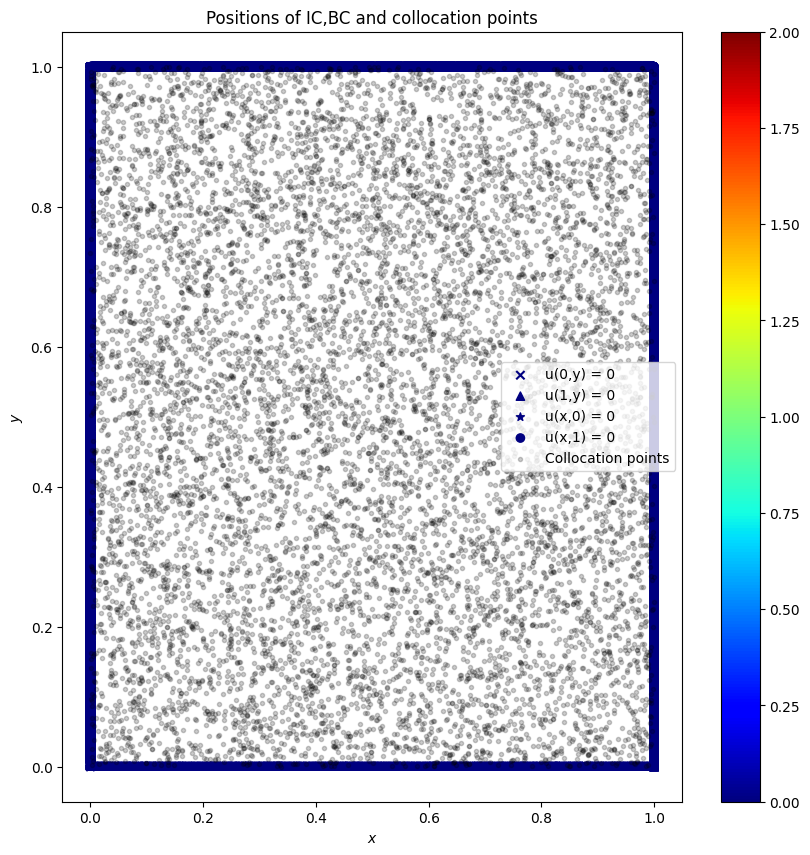

In [ ]:
#Plot Collocation points
fig = plt.figure(figsize=(10,10))
s1 = plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=0, vmax=2,label='u(0,y) = 0',cmap=cm.jet)
plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=0, vmax=2,label='u(1,y) = 0',cmap=cm.jet)
plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=0, vmax=2,label='u(x,0) = 0',cmap=cm.jet)
plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=0, vmax=2,label='u(x,1) = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(s1) # Pass the mappable object from one of the scatter plots
plt.legend(loc='center right')

In [ ]:
#Input layers
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list() # Inititalize params called "list"
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -( jnp.sqrt(6/(n_in + n_out))), (jnp.sqrt(6/(n_in + n_out))) # xavier initialization lower and upper bounds (Check notebook)
    W = lb + (ub - lb) * jax.random.uniform(key,shape=(n_in,n_out)) #Initializing Weight guarantee the random value must be between lb and ub
    B = jax.random.uniform(key,shape=(n_out,)) #Initializing Bias guarantee the random value must be between 0 and 1, the the shape is n_out
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true - pred)**2) #Formular of Mean Squared Error

#Loss boundary and ic conditions

def loss_fun(params,colloc,conds):
  x_c,y_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda x,y : fwd(params,x,y)
  #ufunc_y = lambda x,y:jax.grad(lambda x,y:jnp.sum(ufunc(x,y)),1)(x,y)

  loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)

# Two first Boundary conditions, We implement with DBC
  for cond in conds[0:2] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(ufunc(x_b,y_b),u_b)
# Two final boundary conditions, we implement with DBC, too.
  for cond in conds[2:4] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(ufunc(x_b,y_b),u_b)

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [ ]:
# construct the MLP of  6 hidden layers of 40 neurons for each layer
params = init_params([2]+[10]*4+[1])

In [ ]:
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [ ]:
%%time
epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=1.992e-01
Epoch=100	loss=1.945e-03
Epoch=200	loss=6.364e-04
Epoch=300	loss=5.575e-04
Epoch=400	loss=5.028e-04
Epoch=500	loss=4.545e-04
Epoch=600	loss=4.076e-04
Epoch=700	loss=3.706e-04
Epoch=800	loss=3.475e-04
Epoch=900	loss=3.280e-04
Epoch=1000	loss=3.099e-04
Epoch=1100	loss=2.930e-04
Epoch=1200	loss=2.773e-04
Epoch=1300	loss=1.951e-03
Epoch=1400	loss=2.538e-04
Epoch=1500	loss=2.408e-04
Epoch=1600	loss=1.874e-03
Epoch=1700	loss=2.225e-04
Epoch=1800	loss=2.115e-04
Epoch=1900	loss=2.108e-04
Epoch=2000	loss=1.982e-04
Epoch=2100	loss=1.895e-04
Epoch=2200	loss=1.944e-04
Epoch=2300	loss=4.566e-04
Epoch=2400	loss=6.282e-04
Epoch=2500	loss=1.687e-04
Epoch=2600	loss=4.850e-04
Epoch=2700	loss=2.302e-04
Epoch=2800	loss=1.571e-04
Epoch=2900	loss=1.471e-04
Epoch=3000	loss=1.586e-04
Epoch=3100	loss=1.430e-04
Epoch=3200	loss=5.804e-03
Epoch=3300	loss=1.404e-04
Epoch=3400	loss=1.282e-04
Epoch=3500	loss=1.255e-04
Epoch=3600	loss=1.313e-04
Epoch=3700	loss=1.429e-04
Epoch=3800	loss=1.995e-0



```
# This is formatted as code
```

### Exact solution

In [ ]:


from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import numba

# Parameters
nx = 100
ny = 100
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
def u_exact(x,y,eps):
  return x*y*(1 - np.exp(-(1 - x)/eps))* (1 - np.exp(-(1 - y)/eps))
X, Y = np.meshgrid(x, y)
U_exact = u_exact(X, Y, eps)

In [ ]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

In [ ]:
#Nothing to modify
N=100
X,Y = np.meshgrid(x, y)
pred = (fwd(params,X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))).reshape(N,N)

### Exact solution

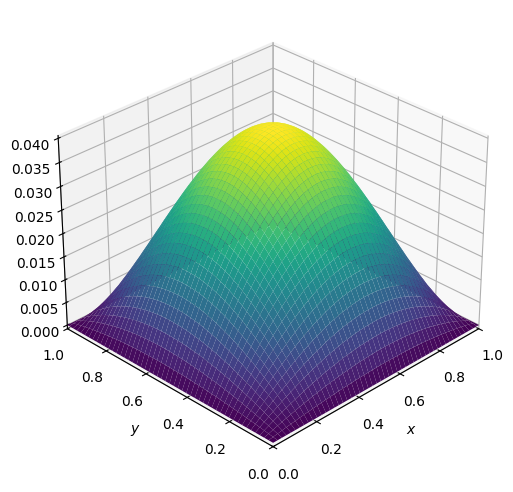

In [ ]:
#Exact Solution
plot2D(X,Y,U_exact)

### PINN solution

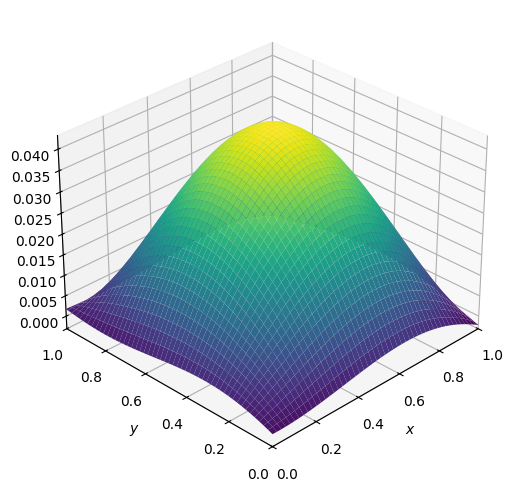

In [ ]:
#prediction
plot2D(X,Y,pred)

###ERROR


Error 0.003920123


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

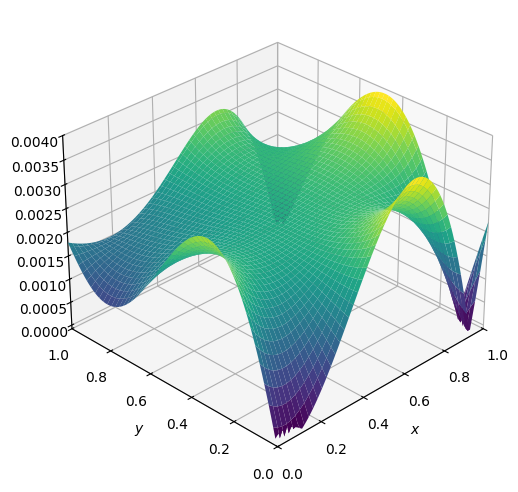

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
N = 100  # Grid size
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Compute error
error = np.abs(U_exact - pred)
print("Error", np.max(error))
# Plot error
plot2D(X,Y,jnp.abs(pred-U_exact))
np.save('Convection-Diffusion Problems-PINN-epsilon = 1.npy', pred)
from google.colab import files
files.download('Convection-Diffusion Problems-PINN-epsilon = 1.npy')